**Selective Halftone Effect - Apply halftone only to the subject**


In [67]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Add src to path to import existing halftone functions
sys.path.insert(0, str(Path.cwd().parent / 'src'))

# Try importing advanced segmentation libraries (optional)
try:
    import rembg
    REMBG_AVAILABLE = True
except ImportError:
    REMBG_AVAILABLE = False
    print("REMBG not available. Install with: pip install rembg")

try:
    import mediapipe as mp
    # Check if solutions API is available (MediaPipe 0.10.x+ removed it)
    if hasattr(mp, 'solutions'):
        MEDIAPIPE_AVAILABLE = True
        MEDIAPIPE_WORKING = True
    else:
        MEDIAPIPE_AVAILABLE = True  # Package is installed
        MEDIAPIPE_WORKING = False  # But API doesn't work
        mp_version = getattr(mp, '__version__', '0.10.x+')
        print(f"⚠️  MediaPipe {mp_version} installed but solutions API removed.")
        print("   MediaPipe 0.10.x+ is not compatible with this code.")
        print("   Note: MediaPipe 0.9.3 not available for Python 3.14+")
        print("   💡 Recommendation: Use REMBG instead (mask_method='rembg')")
except ImportError:
    MEDIAPIPE_AVAILABLE = False
    MEDIAPIPE_WORKING = False
    print("MediaPipe not available. Install with: pip install mediapipe")

REMBG not available. Install with: pip install rembg
⚠️  MediaPipe 0.10.31 installed but solutions API removed.
   MediaPipe 0.10.x+ is not compatible with this code.
   Note: MediaPipe 0.9.3 not available for Python 3.14+
   💡 Recommendation: Use REMBG instead (mask_method='rembg')


In [68]:
def load_image(path):
    """Load image using OpenCV"""
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Could not load image from {path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb

In [69]:
def create_subject_mask_grabcut(image, rect=None, iterations=5):
    """
    Use GrabCut algorithm to segment subject from background.
    Improved version with better initialization.
    
    Args:
        image: RGB image (numpy array)
        rect: Optional tuple (x, y, width, height) for subject bounding box.
              If None, uses automatic detection based on center region.
        iterations: Number of GrabCut iterations (more = better but slower)
    
    Returns:
        Binary mask (0 = background, 1 = foreground)
    """
    # Convert RGB to BGR for OpenCV
    img_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    mask = np.zeros(img_bgr.shape[:2], np.uint8)
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    
    # Define rectangle around subject
    if rect is None:
        height, width = img_bgr.shape[:2]
        # Use center 70% of image, assuming subject is roughly centered
        margin_w = int(width * 0.15)
        margin_h = int(height * 0.15)
        rect = (margin_w, margin_h, 
                width - 2*margin_w, 
                height - 2*margin_h)
    
    # Apply GrabCut
    cv2.grabCut(img_bgr, mask, rect, bgd_model, fgd_model, 
                iterations, cv2.GC_INIT_WITH_RECT)
    
    # Create binary mask
    # GC_BGD (0) and GC_PR_BGD (2) = background
    # GC_FGD (1) and GC_PR_FGD (3) = foreground
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    
    return mask2

In [70]:
def create_subject_mask_saliency(image):
    """
    Use saliency detection to find subject.
    Good for images with clear subject/background contrast.
    """
    # Convert RGB to BGR for OpenCV
    img_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # Try fine-grained saliency first
    # type: ignore - cv2.saliency is a valid module but type checker may not recognize it
    saliency = cv2.saliency.StaticSaliencyFineGrained_create()  # type: ignore
    success, saliency_map = saliency.computeSaliency(img_bgr)
    
    if not success:
        # Fallback to spectral residual
        saliency = cv2.saliency.StaticSaliencySpectralResidual_create()  # type: ignore
        success, saliency_map = saliency.computeSaliency(img_bgr)
    
    if not success:
        return np.ones(image.shape[:2], dtype=np.uint8)  # Return full mask as fallback
    
    # Normalize saliency map
    saliency_map = (saliency_map * 255).astype(np.uint8)
    
    # Adaptive thresholding - use Otsu's method for better results
    _, mask = cv2.threshold(saliency_map, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask = (mask / 255).astype(np.uint8)
    
    # Clean up mask with morphological operations
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    return mask

In [71]:
def create_subject_mask_simple(image):
    """Simple edge-based masking (fallback method)"""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    
    # Dilate edges and fill
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)
    
    # Find contours and create mask from largest contour
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    
    if contours:
        # Get largest contour (assumed to be subject)
        largest_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(mask, [largest_contour], -1, 1, -1)
    
    return mask

In [72]:
def refine_mask(mask, iterations=3, blur_size=15, edge_feather=True):
    """
    Refine mask edges for smoother blending.
    
    Args:
        mask: Binary mask (0 or 1)
        iterations: Morphological operations iterations
        blur_size: Gaussian blur kernel size (odd number)
        edge_feather: If True, creates soft edges for better blending
    
    Returns:
        Float mask [0.0, 1.0] for smooth blending
    """
    # Ensure mask is uint8
    if mask.dtype != np.uint8:
        mask = (mask * 255).astype(np.uint8)
    
    kernel = np.ones((3, 3), np.uint8)
    
    # Smooth the mask with morphological operations
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=iterations)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=iterations)
    
    # Convert to float for blurring
    mask_float = mask.astype(np.float32) / 255.0
    
    if edge_feather:
        # Blur edges for soft transition (feathering)
        # Larger blur_size = softer edges
        mask_blurred = cv2.GaussianBlur(mask_float, (blur_size, blur_size), 0)
        return mask_blurred
    
    return mask_float

In [73]:
def apply_halftone_simple(image, cell_size=10, max_radius=6, bg_color=(255, 255, 255), dot_color=(0, 0, 0)):
    """
    Simplified halftone effect for testing.
    Uses existing halftone generation from src/core/half_tone.py for better quality.
    """
    # Import from src module (path is added in Cell 1)
    from core.pre_processing import preprocess_image  # type: ignore
    from core.half_tone import generate_classic_halftone  # type: ignore
    from config import TARGET_WIDTH, TARGET_HEIGHT  # type: ignore
    
    # Convert PIL to numpy if needed
    if isinstance(image, Image.Image):
        image_np = np.array(image)
    else:
        image_np = image
    
    # Save temporary image for preprocessing
    import tempfile
    with tempfile.NamedTemporaryFile(suffix='.jpg', delete=False) as tmp:
        tmp_path = tmp.name
        Image.fromarray(image_np).save(tmp_path)
    
    try:
        # Use existing preprocessing
        brightness_map = preprocess_image(
            tmp_path,
            image_np.shape[1],  # Use original width
            image_np.shape[0],   # Use original height
            gamma=1.2
        )
        
        # Use existing halftone generation
        config = {
            "cell_size": cell_size,
            "max_radius": max_radius
        }
        
        halftone_img = generate_classic_halftone(
            brightness_map,
            config,
            bg_color,
            dot_color
        )
        
        return np.array(halftone_img)
    finally:
        # Clean up temp file
        import os
        if os.path.exists(tmp_path):
            os.unlink(tmp_path)

In [74]:
def apply_selective_halftone(original, halftone, mask):
    """
    Blend original image with halftone using mask.
    Uses alpha blending for smooth transitions.
    
    Args:
        original: Original RGB image (numpy array, uint8)
        halftone: Halftone-processed RGB image (numpy array, uint8)
        mask: Float mask [0.0, 1.0] where 1.0 = apply halftone
    
    Returns:
        Blended RGB image (numpy array, uint8)
    """
    # Ensure images are same size
    if original.shape[:2] != halftone.shape[:2]:
        halftone = cv2.resize(halftone, (original.shape[1], original.shape[0]))
    
    if original.shape[:2] != mask.shape[:2]:
        mask = cv2.resize(mask, (original.shape[1], original.shape[0]))
    
    # Ensure mask is 3-channel for RGB blending
    if len(mask.shape) == 2:
        mask_3channel = np.stack([mask] * 3, axis=-1)
    else:
        mask_3channel = mask
    
    # Ensure mask is in [0, 1] range
    if mask_3channel.max() > 1.0:
        mask_3channel = mask_3channel.astype(np.float32) / 255.0
    
    # Convert to float for blending
    orig_float = original.astype(np.float32)
    halftone_float = halftone.astype(np.float32)
    
    # Alpha blend: original * (1 - mask) + halftone * mask
    result = (orig_float * (1 - mask_3channel) + halftone_float * mask_3channel)
    
    # Clip and convert back to uint8
    result = np.clip(result, 0, 255).astype(np.uint8)
    
    return result

In [75]:
def selective_halftone_pipeline(image_path, mask_method='grabcut', 
                                 cell_size=10, max_radius=6,
                                 bg_color=(255, 255, 255), dot_color=(0, 0, 0)):
    """
    Complete pipeline for selective halftone effect.
    
    Args:
        image_path: Path to input image
        mask_method: 'rembg', 'mediapipe', 'grabcut', 'saliency', or 'simple'
        cell_size: Halftone cell size in pixels
        max_radius: Maximum dot radius
        bg_color: Background color RGB tuple
        dot_color: Dot color RGB tuple
    
    Returns:
        tuple: (original, mask_refined, halftone, result)
    """
    
    # Load image
    original = load_image(image_path)
    print(f"Loaded image: {original.shape}")
    
    # Create mask
    print(f"Creating subject mask using {mask_method}...")
    if mask_method == 'rembg' and REMBG_AVAILABLE:
        # Function defined in Cell 12 - type checker may not see it
        mask = create_subject_mask_rembg(original)  # type: ignore
    elif mask_method == 'mediapipe':
        if not MEDIAPIPE_AVAILABLE:
            raise ImportError("MediaPipe not installed. Install with: pip install mediapipe")
        elif not MEDIAPIPE_WORKING:
            raise ImportError(
                "MediaPipe 0.10.x+ removed the solutions API and is not compatible.\n"
                "MediaPipe 0.9.3 is not available for Python 3.14+.\n\n"
                "💡 Use REMBG instead (recommended): mask_method='rembg'\n"
                "   REMBG works with current versions and provides better quality."
            )
        # Function defined in Cell 12 - type checker may not see it
        mask = create_subject_mask_mediapipe(original)  # type: ignore
    elif mask_method == 'grabcut':
        mask = create_subject_mask_grabcut(original)
    elif mask_method == 'saliency':
        mask = create_subject_mask_saliency(original)
    else:
        mask = create_subject_mask_simple(original)
    
    print(f"Mask created: {mask.shape}, coverage: {mask.mean():.2%}")
    
    # Refine mask
    mask_refined = refine_mask(mask)
    
    # Apply halftone to entire image
    print("Applying halftone effect...")
    halftone = apply_halftone_simple(original, cell_size, max_radius, bg_color, dot_color)
    
    # Combine using mask
    print("Blending original with halftone...")
    result = apply_selective_halftone(original, halftone, mask_refined)
    
    return original, mask_refined, halftone, result

In [76]:
def visualize_results(original, mask, halftone, result):
    """Display all stages of the process"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    axes[0, 0].imshow(original)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(mask, cmap='gray')
    axes[0, 1].set_title('Subject Mask')
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(halftone)
    axes[1, 0].set_title('Full Halftone Effect')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(result)
    axes[1, 1].set_title('Selective Halftone (Subject Only)')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

Loaded image: (1104, 736, 3)
Creating subject mask using grabcut...
Mask created: (1104, 736), coverage: 1.11%
Applying halftone effect...
Blending original with halftone...


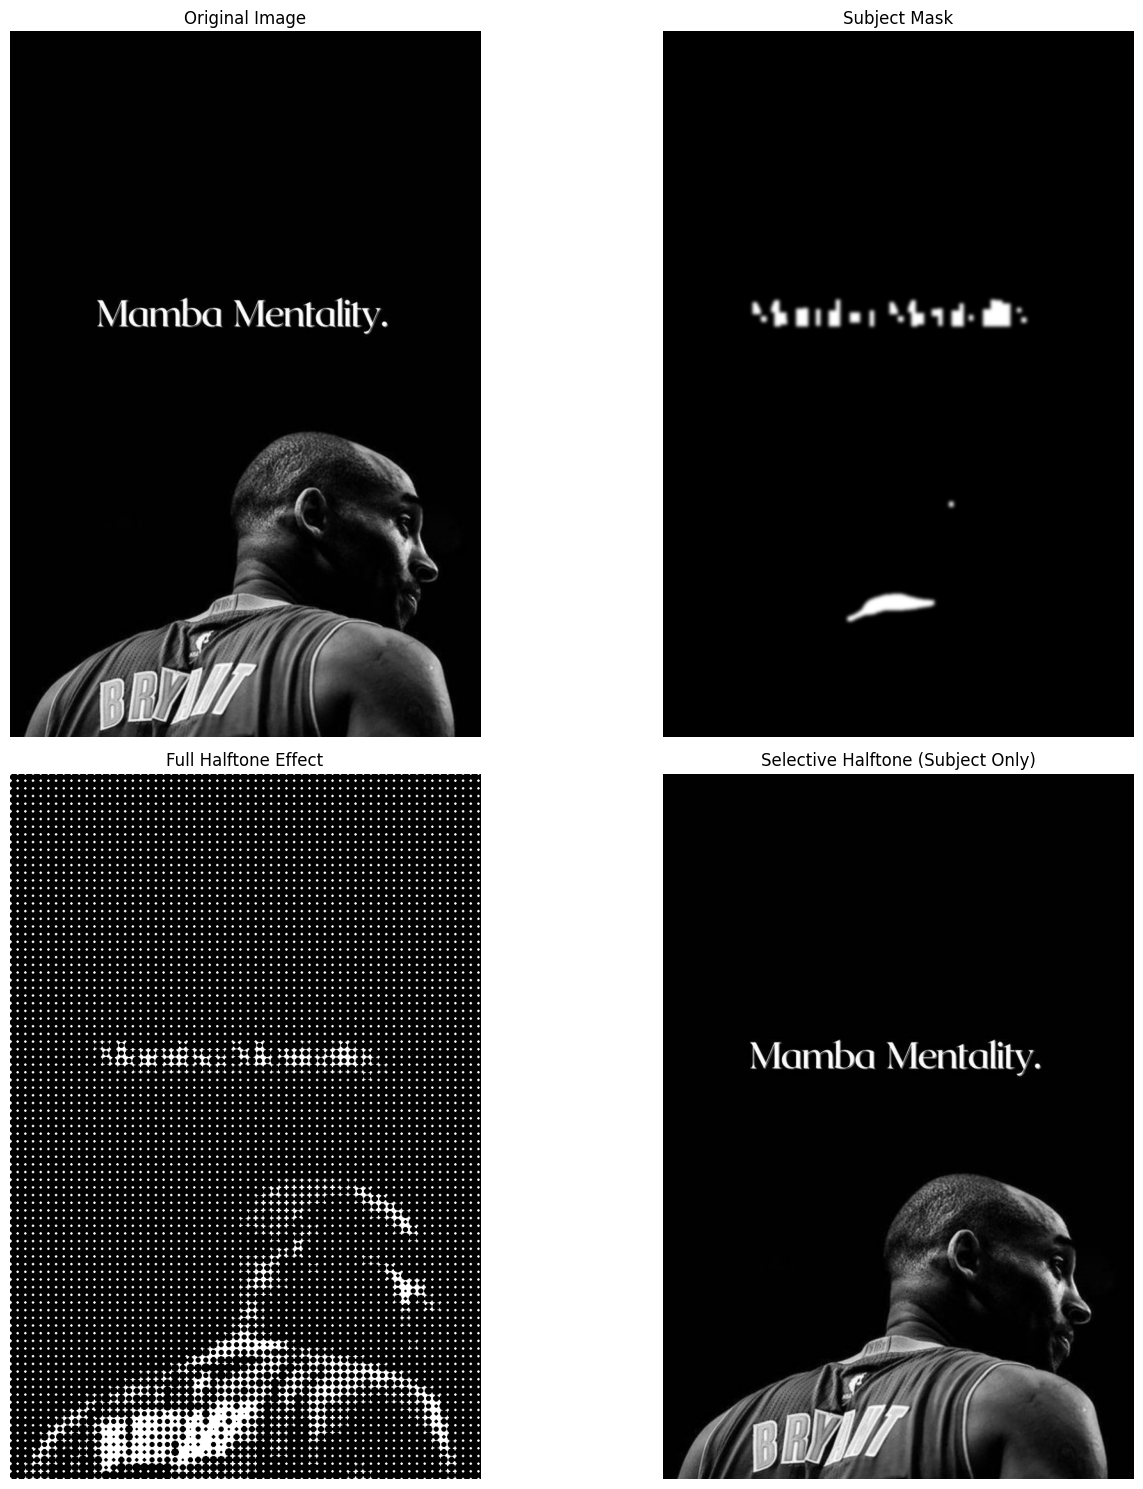

In [77]:
# Test with GrabCut method
original, mask, halftone, result = selective_halftone_pipeline(
    '../assets/samples/portrait.jpg',
    mask_method='grabcut',
    cell_size=12,
    max_radius=7
)

# Visualize results
visualize_results(original, mask, halftone, result)

In [78]:
# ============================================================================
# ADVANCED SEGMENTATION METHODS
# ============================================================================

def create_subject_mask_rembg(image):
    """
    Use REMBG library for high-quality background removal.
    REMBG uses deep learning models (U2Net) for accurate segmentation.
    
    Install: pip install rembg
    
    This is the RECOMMENDED method for best quality results.
    """
    if not REMBG_AVAILABLE:
        raise ImportError("REMBG not available. Install with: pip install rembg")
    
    # REMBG expects PIL Image or numpy array
    if isinstance(image, np.ndarray):
        pil_image = Image.fromarray(image)
    else:
        pil_image = image
    
    # Create remover instance (uses u2net model by default)
    remover = rembg.new_session()
    
    # Remove background
    output = rembg.remove(pil_image, session=remover)
    
    # Convert to numpy and extract alpha channel as mask
    output_np = np.array(output)
    
    if output_np.shape[2] == 4:  # RGBA
        mask = output_np[:, :, 3]  # Alpha channel
    else:
        # If no alpha, create mask from non-transparent pixels
        mask = (output_np.sum(axis=2) > 0).astype(np.uint8) * 255
    
    # Normalize to [0, 1]
    mask = (mask / 255.0).astype(np.float32)
    
    return mask


def create_subject_mask_mediapipe(image):
    """
    Use MediaPipe Selfie Segmentation for fast, accurate person segmentation.
    Best for portraits and people photos.
    
    NOTE: MediaPipe 0.10.x+ removed the old solutions API. 
    This function requires MediaPipe < 0.10 (e.g., 0.9.3).
    
    To use MediaPipe, downgrade with: pip install mediapipe==0.9.3
    
    Alternatively, use REMBG method which works with current versions and provides better quality.
    """
    if not MEDIAPIPE_AVAILABLE:
        raise ImportError("MediaPipe not available. Install with: pip install mediapipe==0.9.3")
    
    # Check if solutions API is available (MediaPipe 0.10.x+ removed it)
    if not hasattr(mp, 'solutions'):
        # Get version for error message
        mp_version = getattr(mp, '__version__', '0.10.x+')
        import sys
        python_version = f"{sys.version_info.major}.{sys.version_info.minor}"
        raise ImportError(
            f"MediaPipe {mp_version} removed the solutions API.\n\n"
            f"This function requires MediaPipe < 0.10 (e.g., 0.9.3).\n"
            f"However, MediaPipe 0.9.3 is not available for Python {python_version}+.\n\n"
            "💡 Solution: Use REMBG instead (recommended):\n"
            "   mask_method='rembg'\n"
            "   REMBG works with current versions and provides better quality."
        )
    
    # Use old solutions API (MediaPipe < 0.10)
    mp_selfie_segmentation = mp.solutions.selfie_segmentation  # type: ignore
    selfie_segmentation_model = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)
    
    # MediaPipe expects RGB
    if isinstance(image, np.ndarray):
        image_rgb = image
    else:
        image_rgb = np.array(image)
    
    # Process image
    results = selfie_segmentation_model.process(image_rgb)
    
    # Get segmentation mask
    mask = results.segmentation_mask
    
    # Convert to binary (threshold at 0.5)
    mask = (mask > 0.5).astype(np.float32)
    
    # Clean up
    selfie_segmentation_model.close()
    
    return mask


## Recommended Segmentation Methods (Best to Good)

1. **REMBG** (`mask_method='rembg'`) - **BEST QUALITY** ⭐ RECOMMENDED
   - Uses U2Net deep learning model
   - Works for any subject (people, objects, animals)
   - Very accurate, handles complex backgrounds
   - Install: `pip install rembg`
   - Slightly slower but best results
   - **Works with latest versions**

2. **MediaPipe** (`mask_method='mediapipe'`) - **BEST FOR PEOPLE** ⚠️ **NOT COMPATIBLE**
   - Optimized for person/selfie segmentation
   - Very fast, real-time capable
   - Works great for portraits
   - **❌ NOT AVAILABLE**: MediaPipe 0.10.x+ removed the solutions API
   - **❌ MediaPipe 0.9.3 not available for Python 3.14+**
   - May not work well for non-people subjects
   - **💡 Use REMBG instead** - works with current versions and better quality

3. **GrabCut** (`mask_method='grabcut'`) - **GOOD BALANCE**
   - Built into OpenCV, no extra dependencies
   - Works reasonably well with good initialization
   - Can be improved with manual rectangle selection
   - Moderate speed and quality

4. **Saliency** (`mask_method='saliency'`) - **QUICK & DIRTY**
   - Fast, no dependencies
   - Works when subject is visually distinct
   - May miss fine details

5. **Simple** (`mask_method='simple'`) - **FALLBACK**
   - Edge-based, very basic
   - Use only if others fail


In [79]:
# Test with REMBG (best quality) - RECOMMENDED
if REMBG_AVAILABLE:
    print("Testing REMBG method (best quality)...")
    original_rembg, mask_rembg, halftone_rembg, result_rembg = selective_halftone_pipeline(
        '../assets/samples/portrait2.jpg',
        mask_method='rembg',
        cell_size=12,
        max_radius=7,
        bg_color=(255, 255, 255),
        dot_color=(0, 0, 0)
    )
    
    visualize_results(original_rembg, mask_rembg, halftone_rembg, result_rembg)
else:
    print("REMBG not available. Install with: pip install rembg")


REMBG not available. Install with: pip install rembg


In [80]:
# Test with MediaPipe (best for people/portraits)
# NOTE: MediaPipe 0.10.x+ removed the solutions API and is NOT compatible
# MediaPipe 0.9.3 is not available for Python 3.14+
if MEDIAPIPE_AVAILABLE and MEDIAPIPE_WORKING:
    print("Testing MediaPipe method (fast, good for people)...")
    original_mp, mask_mp, halftone_mp, result_mp = selective_halftone_pipeline(
        '../assets/samples/portrait2.jpg',
        mask_method='mediapipe',
        cell_size=12,
        max_radius=7
    )
    
    visualize_results(original_mp, mask_mp, halftone_mp, result_mp)
elif MEDIAPIPE_AVAILABLE and not MEDIAPIPE_WORKING:
    print("❌ MediaPipe is installed but not compatible with this Python version.")
    print("   MediaPipe 0.10.x+ removed the solutions API.")
    print("   MediaPipe 0.9.3 is not available for Python 3.14+.\n")
    print("💡 Recommendation: Use REMBG instead (better quality, works with current versions):")
    print("   Run the REMBG test cell above, or use: mask_method='rembg'")
else:
    print("MediaPipe not available. Install with: pip install mediapipe")


❌ MediaPipe is installed but not compatible with this Python version.
   MediaPipe 0.10.x+ removed the solutions API.
   MediaPipe 0.9.3 is not available for Python 3.14+.

💡 Recommendation: Use REMBG instead (better quality, works with current versions):
   Run the REMBG test cell above, or use: mask_method='rembg'


In [81]:
# Compare all methods side by side
def compare_methods(image_path, methods=['grabcut', 'saliency', 'simple']):
    """Compare different segmentation methods"""
    original = load_image(image_path)
    
    fig, axes = plt.subplots(len(methods), 4, figsize=(20, 5*len(methods)))
    
    for idx, method in enumerate(methods):
        try:
            print(f"\nTesting {method}...")
            _, mask, halftone, result = selective_halftone_pipeline(
                image_path,
                mask_method=method,
                cell_size=12,
                max_radius=7
            )
            
            axes[idx, 0].imshow(original)
            axes[idx, 0].set_title(f'{method.upper()}\nOriginal')
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(mask, cmap='gray')
            axes[idx, 1].set_title('Mask')
            axes[idx, 1].axis('off')
            
            axes[idx, 2].imshow(halftone)
            axes[idx, 2].set_title('Full Halftone')
            axes[idx, 2].axis('off')
            
            axes[idx, 3].imshow(result)
            axes[idx, 3].set_title('Selective Halftone')
            axes[idx, 3].axis('off')
            
        except Exception as e:
            print(f"Error with {method}: {e}")
            for j in range(4):
                axes[idx, j].axis('off')
                axes[idx, j].text(0.5, 0.5, f'Error: {method}', 
                                 ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

# Uncomment to compare methods
# compare_methods('../assets/samples/portrait2.jpg', 
#                 methods=['grabcut', 'saliency', 'simple'])


Loaded image: (1104, 736, 3)
Creating subject mask using simple...
Mask created: (1104, 736), coverage: 9.72%
Applying halftone effect...
Blending original with halftone...


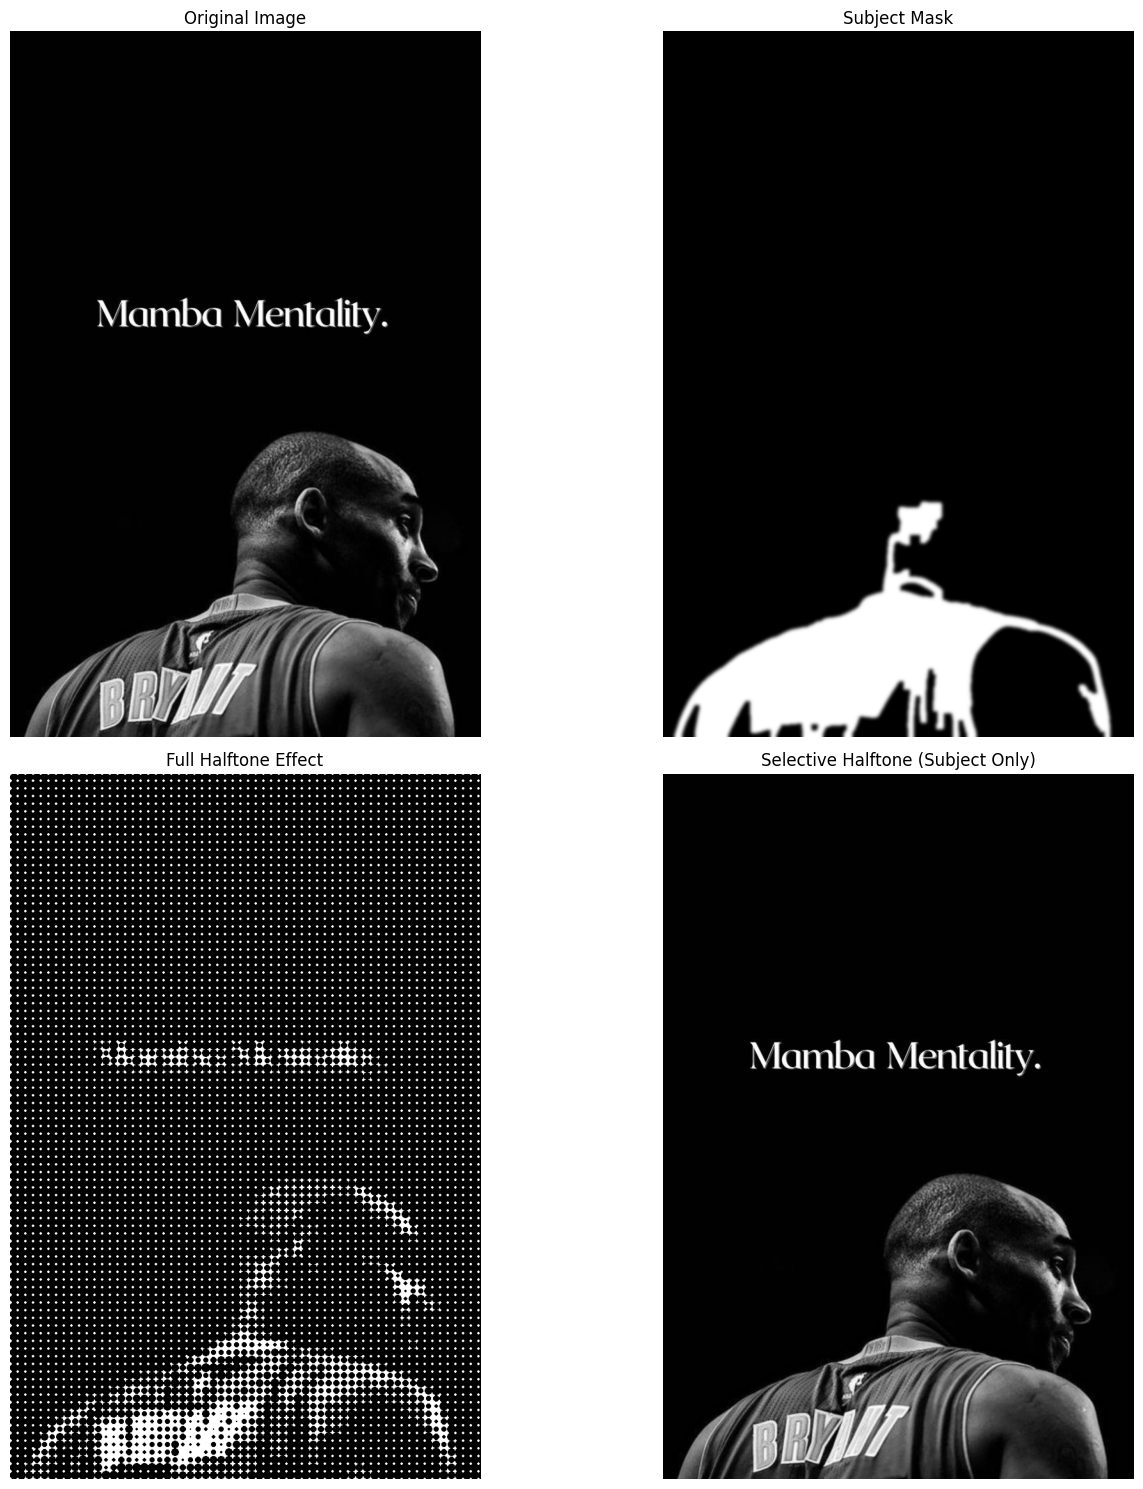

In [82]:
# Test with Simple edge-based method
original3, mask3, halftone3, result3 = selective_halftone_pipeline(
    '../assets/samples/portrait.jpg',
    mask_method='simple',
    cell_size=12,
    max_radius=7
)

visualize_results(original3, mask3, halftone3, result3)